# Networkcaster
1. Change a Quetzal model projection
1. Split a Quetzal model
2. Use the networkcaster method
3. Combine quetzal models
4. Monitore the results

In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
import pandas as pd
from quetzal.model import stepmodel, model

if manual:
    %matplotlib inline

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
sm = stepmodel.read_zip(training_folder + 'model/base/networks.zip')

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 17.14it/s]


Convert the model into epsg 2154 (Lambert 93).

# Networkcaster
Must be done on a clean network

In [6]:
sm.integrity_fix_sequences()

In [7]:
sm.integrity_fix_nodeset_consistency()
sm.integrity_test_all(errors='raise', verbose=False)

5926it [00:01, 5071.95it/s]
5926it [00:04, 1359.80it/s]


# Split model
Into two models: one for rail-based modes, on for road-based modes

## rail
Dumb networkcasting of rail-based PT links

In [8]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|███████████████████████████████████████████████████████████| 30220/30220 [00:00<00:00, 31377.65it/s]


1. Plot rail.links and rail.nodes
2. Plot the subset of rail.nodes that are used by rail.links
2. Identify the new columns created in rail.links GeoDataFrame by the preparation_cast_network method

## road
Networcasting of road-base PT links

In [10]:
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [11]:
len(sm.road_nodes), len(sm.road_links)

(5926, 10074)

In [12]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=1,
    replace_nodes=False
)

100100077:77_1: 100%|████████████████████████████████████████████████████████████████| 243/243 [01:39<00:00,  2.44it/s]


## both road and rail

In [13]:
both = road.copy()
both.links = pd.concat([road.links, rail.links]) 

In [14]:
both.analysis_lines(line_columns='all')  # Build lines

Plot the first 10 lines

# to_zip

In [16]:
both.to_zip(training_folder + 'model/base/road_model.zip' )  

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


could not save attribute: missing_nodes
could not save attribute: orphan_nodes
could not save attribute: missing_road_nodes
could not save attribute: networkcaster


# monitoring
Check road.links new geometries by comparing the line length on the road and its length on straigth line between stops

1. Get the straight length of all links:
    1. add a `'straigth_geometry'` column containing the straigth line geometry, using shapely
    2. add a `'link_straigth_length'` column containing the length of this geometry
2. Aggregate this data at line level:
    1. use `road.analysis_lines(sum_columns=['link_straigth_length'])` to obtain the lines with the sum of the straith length of all links
    2. get the lines road length
3. Compare
    1. compute the ratios between `link_straigth_length` and `length` for all lines
    2. plot these ratios using matplotlib `hist` method

1. Save the `lines` dataframe
2. Rerun the networkcasting step with different parameters (that we should discuss together: no value greater than 6)
3. monitore the result using the same process
4. Discuss the results

Export the lines as a shp or geojson file and display it on QGis.  
Note: to easily export geojson file, you can use the sm.to_json() method with specific attributes as parameters

# plot

In [20]:
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'

import matplotlib.pyplot as plt
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    buffer = raw.copy()
    buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(500))

    plot = raw.plot(
        'road_nodes', markersize=0.3, color='green',
        ax=raw.plot('road_links', linewidth=0.3, color='green',
                   ax=buffer.plot('zones', alpha=0, ax=ax_array[0][0])
                  ),
        basemap_url=url,title="Road network", fontsize=36
    )
    plot = raw.plot('links', 
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[0][1]),
        basemap_url=url, title="GTFS", fontsize=36
    )
    plot = raw.plot('links', ax=raw.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[1][0])),
        basemap_url=url,title="raw GTFS & road network", fontsize=36
    )
    plot = processed.plot(
        'links', 
        ax=processed.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                     ax=buffer.plot('zones', alpha=0, ax=ax_array[1][1])),
        basemap_url=url,title="Processed GTFS & Road Network", fontsize=36
    )
    return fig

Reprojecting model from epsg 2154 to epsg 3857: 100%|██████████████████████████████████| 40/40 [00:14<00:00,  2.80it/s]


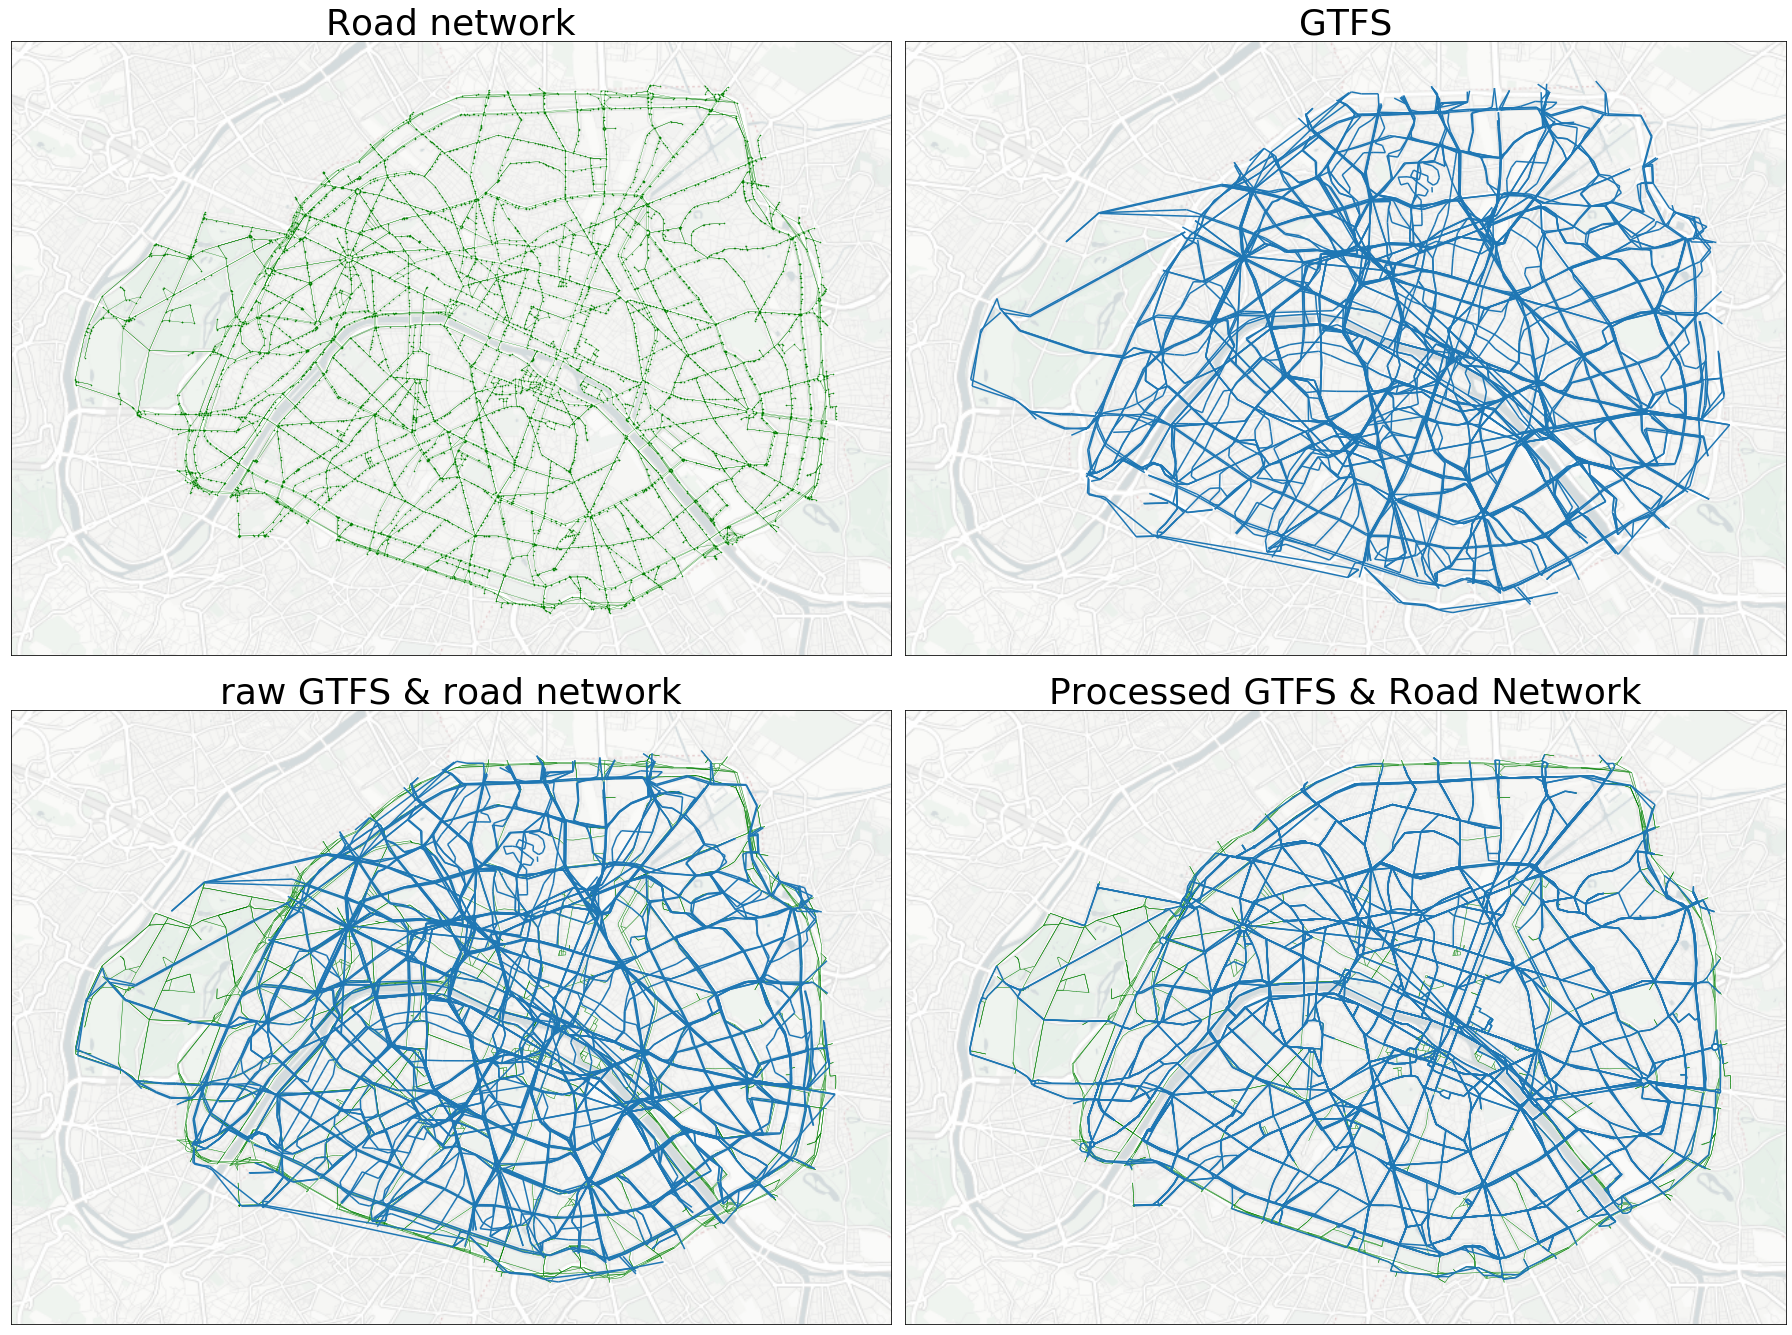

In [21]:
if manual:
    fig = plot_networkcaster(
        raw=sm.change_epsg(epsg=3857, coordinates_unit='meter'),
        processed=both.change_epsg(epsg=3857, coordinates_unit='meter'),
        url=url
    )